#**Capital bike diaries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pygeohash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.6 MB/s eta 0:00:00


In [3]:
import os
from pathlib import Path
import scipy
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import sklearn
import folium
import pygeohash as pgh

##Cleaning and data integration

In [4]:
!cp -r "/content/drive/MyDrive/Dataset data" /content/


In [5]:
folder_path = Path('/content/Dataset data/')
#بيانات الرحلات اليومية
df_all_rent = pd.read_parquet(folder_path / "daily-rent.parquet") #df_rent: يحتوي على كافة الرحلات اليومية لاستئجار الدراجات
df_rent = pd.read_parquet(folder_path / "daily-rent-sampled.parquet") # نسخة مُصغّرة أو عيّنة من df_rent
#بيانات الطقس
df_weather = pd.read_csv(folder_path / "Washington,DC,USA 2024-01-01 to 2024-12-31.csv") # يحتوي على بيانات الطقس اليومية في واشنطن العاصمة من 1 يناير إلى 31 ديسمبر 2024.
#بيانات المحطات
df_stations_table = pd.read_csv(folder_path / "stations.csv") #جدول إضافي للمحطات، قد يحتوي على تفاصيل أخرى مثل معرّف المحطة (ID)، الاسم، عدد الأرصفة، إلخ
df_stations_info = pd.read_csv(folder_path / "Capital_Bikeshare_Locations.csv")  #معلومات حول مواقع محطات استئجار الدراجات الإحداثيات، اسم المحطة، إلخ.
#بيانات جغرافية ومناطق
df_cbd = gpd.read_file(folder_path / "DDOT_Central_Business_District.geojson") # المنطقة التجارية المركزية – تُستخدم لتحديد ما إذا كانت الرحلة بدأت أو انتهت داخل هذه المنطقة.
df_zones = gpd.read_file(folder_path / "Residential_and_Visitor_Parking_Zones.geojson") #مناطق وقوف السيارات السكنية والزوار (Residential and Visitor Parking Zones).
#بيانات النقل العام
df_metro = pd.read_csv(folder_path / "Metro_Bus_Stops.csv") #مواقف حافلات المترو (Metro Bus Stops).
df_shuttle = pd.read_csv(folder_path / "Shuttle_Bus_Stops.csv") # مواقف حافلات النقل الصغيرة (Shuttle Bus Stops).



In [6]:
df_rent.shape

(2018456, 13)

In [7]:
df_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018456 entries, 0 to 2018455
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 200.2+ MB


In [8]:
df_rent.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng
count,2018456,2018456,2.018456e+06,2.018456e+06,2.016904e+06,2.016904e+06
mean,2024-07-18 17:20:21.606335488,2024-07-18 18:32:57.616510208,3.890581e+01,-7.703182e+01,3.890509e+01,-7.703160e+01
min,1970-01-01 00:00:00,2000-01-01 15:55:56,0.000000e+00,-7.739000e+01,0.000000e+00,-8.018000e+01
25%,2024-05-03 10:31:50.249999872,2024-05-03 10:53:36.750000128,3.889287e+01,-7.704440e+01,3.889227e+01,-7.704442e+01
50%,2024-07-26 11:24:29.612000,2024-07-26 11:42:10.036499968,3.890543e+01,-7.703000e+01,3.890383e+01,-7.703000e+01
75%,2024-10-06 17:19:02.340999936,2024-10-06 17:40:53.261750016,3.891902e+01,-7.701162e+01,3.891776e+01,-7.701082e+01
max,2024-12-31 23:54:29.513000,2030-01-01 00:00:00,3.914000e+01,0.000000e+00,4.217000e+01,0.000000e+00
std,NaN,NaN,9.114090e-02,1.753559e-01,9.134485e-02,1.754522e-01


In [9]:
print(df_rent.nunique())

ride_id               2018430
rideable_type               2
started_at            1989352
ended_at              1989525
start_station_name        816
start_station_id          802
end_station_name          814
end_station_id            800
start_lat              244715
start_lng              252932
end_lat                   914
end_lng                   934
member_casual               2
dtype: int64


In [10]:
print(df_rent.duplicated().sum())

0


In [11]:
print(df_rent.isnull().mean()*100)

ride_id                0.000000
rideable_type          0.000000
started_at             0.000000
ended_at               0.000000
start_station_name    19.484695
start_station_id      19.484695
end_station_name      20.244979
end_station_id        20.271287
start_lat              0.000000
start_lng              0.000000
end_lat                0.076890
end_lng                0.076890
member_casual          0.000000
dtype: float64


In [12]:
print(df_rent.isnull().sum())

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    393290
start_station_id      393290
end_station_name      408636
end_station_id        409167
start_lat                  0
start_lng                  0
end_lat                 1552
end_lng                 1552
member_casual              0
dtype: int64


In [13]:
df_rent.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37,2024-05-04 14:37:52,14th & G St NW,31238,Jefferson Memorial,31249,38.898164,-77.031898,38.879819,-77.037413,casual
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53,2024-05-04 15:00:25,Jefferson Dr & 14th St SW,31247,7th & F St NW / National Portrait Gallery,31232,38.888553,-77.032427,38.897283,-77.022191,casual
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21,2024-05-04 15:27:29,1st & M St NE,31603,4th & M St SW,31108,38.905697,-77.005483,38.876823,-77.017774,casual
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59,2024-05-04 14:54:11,Jefferson Memorial,31249,Hains Point/Buckeye & Ohio Dr SW,31273,38.879819,-77.037413,38.878433,-77.030230,casual
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20,2024-05-04 19:41:35,New Hampshire Ave & T St NW,31229,14th & G St NW,31238,38.915544,-77.038252,38.898164,-77.031898,casual


<Axes: >

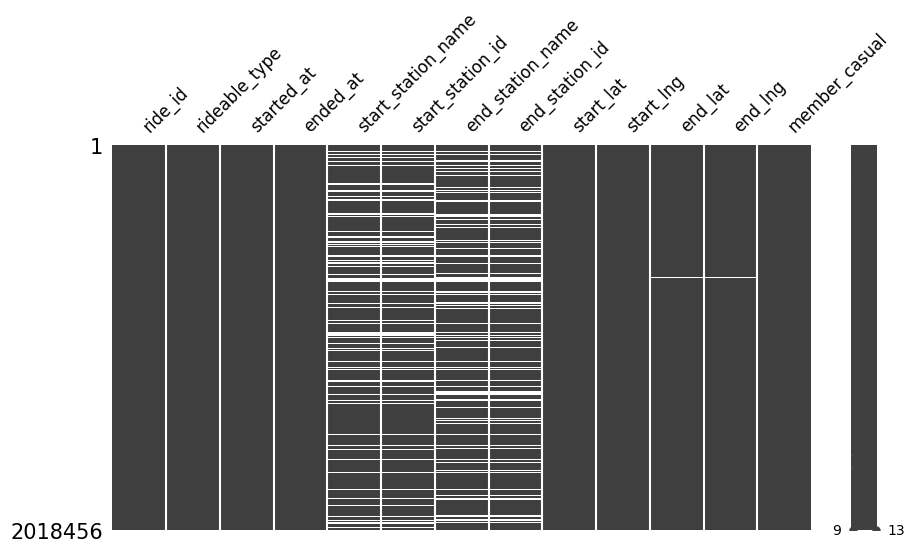

In [14]:
import missingno as msno
msno.matrix(df_rent,figsize=(10,5), fontsize=12)

<Axes: >

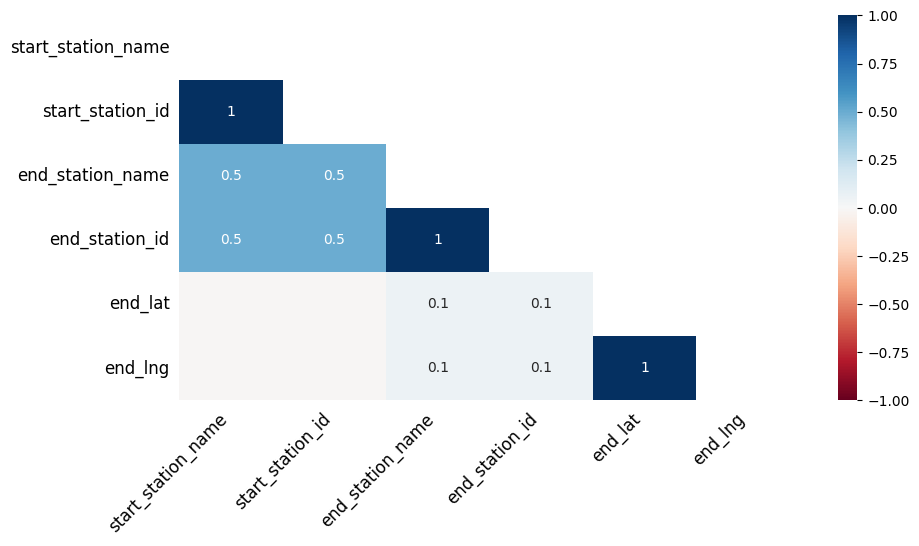

In [15]:
msno.heatmap(df_rent, figsize=(10,5), fontsize=12)

<Axes: >

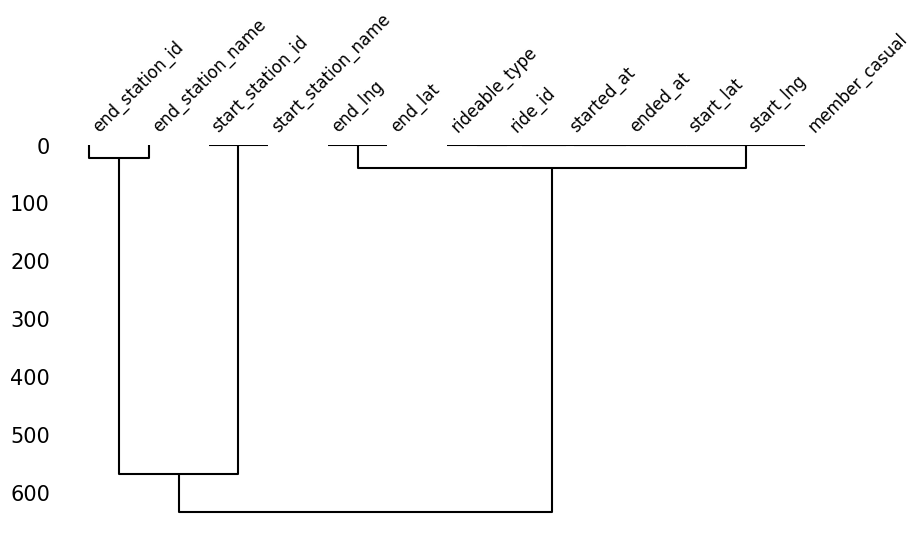

In [16]:
msno.dendrogram(df_rent, figsize=(10,5), fontsize=12)

In [17]:
# df_rent['end_lat'].fillna(df_rent['end_lat'].median(), inplace=True)
# df_rent['end_lng'].fillna(df_rent['end_lng'].median(), inplace=True)

In [18]:
df_rent.fillna({
    'end_lat': df_rent['end_lat'].median(),
    'end_lng': df_rent['end_lng'].median()
}, inplace=True)

In [19]:
# df_rent["end_lat"]=df_rent["end_lat"].fillna(method='ffill')
# df_rent["end_lng"]=df_rent["end_lng"].fillna(method='ffill')

In [20]:
print(df_rent.isnull().sum())

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    393290
start_station_id      393290
end_station_name      408636
end_station_id        409167
start_lat                  0
start_lng                  0
end_lat                    0
end_lng                    0
member_casual              0
dtype: int64


In [21]:
categorical_cols = ['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id']
df_rent[categorical_cols] = df_rent[categorical_cols].fillna(df_rent[categorical_cols].mode().iloc[0])

print(df_rent.isnull().sum())

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64


In [22]:
print(df_rent.nunique())

ride_id               2018430
rideable_type               2
started_at            1989352
ended_at              1989525
start_station_name        816
start_station_id          802
end_station_name          814
end_station_id            800
start_lat              244715
start_lng              252932
end_lat                   914
end_lng                   934
member_casual               2
dtype: int64


In [23]:
df_rent.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37,2024-05-04 14:37:52,14th & G St NW,31238,Jefferson Memorial,31249,38.898164,-77.031898,38.879819,-77.037413,casual
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53,2024-05-04 15:00:25,Jefferson Dr & 14th St SW,31247,7th & F St NW / National Portrait Gallery,31232,38.888553,-77.032427,38.897283,-77.022191,casual
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21,2024-05-04 15:27:29,1st & M St NE,31603,4th & M St SW,31108,38.905697,-77.005483,38.876823,-77.017774,casual
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59,2024-05-04 14:54:11,Jefferson Memorial,31249,Hains Point/Buckeye & Ohio Dr SW,31273,38.879819,-77.037413,38.878433,-77.030230,casual
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20,2024-05-04 19:41:35,New Hampshire Ave & T St NW,31229,14th & G St NW,31238,38.915544,-77.038252,38.898164,-77.031898,casual


In [24]:
df_rent['start_station_id'] = df_rent['start_station_id'].astype('Int64')
df_rent['end_station_id'] = df_rent['end_station_id'].astype('Int64')

In [25]:
df_stations_table.shape

(821, 2)

In [26]:
df_stations_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      821 non-null    int64 
 1   name    821 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [27]:
print(df_stations_table.nunique())

id      804
name    820
dtype: int64


In [28]:
print(df_stations_table.isnull().sum())

id      0
name    0
dtype: int64


In [29]:
df_stations_table.head()

,id,name
0,30200,9th St & Pennsylvania Ave NW
1,30201,9th & G St NW
2,31000,Eads St & 15th St S
3,31002,Crystal Dr & 20th St S
4,31003,Crystal Dr & 15th St S


In [30]:
df_stations_info.shape

(794, 29)

In [31]:
df_stations_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   X                               794 non-null    float64
 1   Y                               794 non-null    float64
 2   NAME                            794 non-null    object 
 3   STATION_TYPE                    794 non-null    object 
 4   STATION_ID                      794 non-null    object 
 5   STATION_STATUS                  0 non-null      float64
 6   LAST_REPORTED                   794 non-null    object 
 7   NUM_DOCKS_AVAILABLE             794 non-null    int64  
 8   NUM_DOCKS_DISABLED              794 non-null    int64  
 9   NUM_BIKES_AVAILABLE             794 non-null    int64  
 10  NUM_EBIKES_AVAILABLE            794 non-null    int64  
 11  NUM_BIKES_DISABLED              794 non-null    int64  
 12  IS_INSTALLED                    794 

In [32]:
print(df_stations_info.nunique())

X                                 794
Y                                 794
NAME                              794
STATION_TYPE                        1
STATION_ID                        794
STATION_STATUS                      0
LAST_REPORTED                     125
NUM_DOCKS_AVAILABLE                33
NUM_DOCKS_DISABLED                  3
NUM_BIKES_AVAILABLE                31
NUM_EBIKES_AVAILABLE               10
NUM_BIKES_DISABLED                  8
IS_INSTALLED                        2
IS_RETURNING                        2
IS_RENTING                          2
HAS_KIOSK                           2
IOS                                 1
ANDROID                             1
ELECTRIC_BIKE_SURCHARGE_WAIVER      1
EIGHTD_HAS_KEY_DISPENSER            1
CAPACITY                           29
RENTAL_METHODS                      1
REGION_ID                           8
REGION_NAME                         1
GIS_ID                              0
LATITUDE                          789
LONGITUDE   

In [33]:
print(df_stations_info.isnull().sum())

X                                   0
Y                                   0
NAME                                0
STATION_TYPE                        0
STATION_ID                          0
STATION_STATUS                    794
LAST_REPORTED                       0
NUM_DOCKS_AVAILABLE                 0
NUM_DOCKS_DISABLED                  0
NUM_BIKES_AVAILABLE                 0
NUM_EBIKES_AVAILABLE                0
NUM_BIKES_DISABLED                  0
IS_INSTALLED                        0
IS_RETURNING                        0
IS_RENTING                          0
HAS_KIOSK                           0
IOS                                 0
ANDROID                             0
ELECTRIC_BIKE_SURCHARGE_WAIVER      0
EIGHTD_HAS_KEY_DISPENSER            0
CAPACITY                            0
RENTAL_METHODS                      0
REGION_ID                          50
REGION_NAME                         0
GIS_ID                            794
LATITUDE                            0
LONGITUDE   

In [34]:
df_stations_info.head()

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
0,-8.577104e+06,4.705679e+06,Lincoln Memorial,classic,08254284-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,17,0,8,...,NO,25,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888255,-77.049437,2025/05/05 20:27:29+00,261284028
1,-8.609481e+06,4.714716e+06,W&OD Trail/Sunset Hills Rd & Isaac Newton Sq,classic,08263fbd-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,15,0,3,...,NO,19,"KEY,CREDITCARD",104.0,DCA-CABI,NaN,38.951419,-77.340281,2025/05/05 20:27:29+00,261284029
2,-8.575867e+06,4.705657e+06,17th St & Independence Ave SW,classic,082623bf-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,10,0,6,...,NO,19,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888097,-77.038325,2025/05/05 20:27:29+00,261284030
3,-8.574188e+06,4.706622e+06,8th & D St NW,classic,08256ac9-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,0,0,24,...,NO,24,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.894851,-77.023240,2025/05/05 20:27:29+00,261284031
4,-8.567161e+06,4.706864e+06,Anacostia Ave & Benning Rd NE / River Terrace,classic,082518eb-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,4,0,10,...,NO,15,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.896544,-76.960120,2025/05/05 20:27:29+00,261284032


In [35]:
# # مثال: إزالة مسافات زائدة وتحويل إلى حروف صغيرة
# df_stations_info['clean_name'] = df_stations_info['NAME'].str.strip().str.lower()
# df_stations_table['clean_name'] = df_stations_table['name'].str.strip().str.lower()

# # الآن حاول الدمج باستخدام الأسماء المنظفة
# merged_df = pd.merge(df_stations_info, df_stations_table, left_on='clean_name', right_on='clean_name', how='left')


In [36]:
merged_df = pd.merge(df_stations_info, df_stations_table, left_on='NAME', right_on='name', how='left')

df_stations_info['id'] = merged_df['id']


In [37]:
df_stations_info.head()

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID,id
0,-8.577104e+06,4.705679e+06,Lincoln Memorial,classic,08254284-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,17,0,8,...,25,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888255,-77.049437,2025/05/05 20:27:29+00,261284028,31258.0
1,-8.609481e+06,4.714716e+06,W&OD Trail/Sunset Hills Rd & Isaac Newton Sq,classic,08263fbd-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,15,0,3,...,19,"KEY,CREDITCARD",104.0,DCA-CABI,NaN,38.951419,-77.340281,2025/05/05 20:27:29+00,261284029,32220.0
2,-8.575867e+06,4.705657e+06,17th St & Independence Ave SW,classic,082623bf-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,10,0,6,...,19,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888097,-77.038325,2025/05/05 20:27:29+00,261284030,31290.0
3,-8.574188e+06,4.706622e+06,8th & D St NW,classic,08256ac9-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,0,0,24,...,24,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.894851,-77.023240,2025/05/05 20:27:29+00,261284031,31270.0
4,-8.567161e+06,4.706864e+06,Anacostia Ave & Benning Rd NE / River Terrace,classic,082518eb-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,4,0,10,...,15,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.896544,-76.960120,2025/05/05 20:27:29+00,261284032,31708.0


In [38]:
no_match = df_stations_info[df_stations_info['id'].isnull()]
print(no_match[['NAME']])

                                                  NAME
12                         Martha Custis Dr & Lyons Ln
19                                Herndon Metro South 
65                              D St & Maryland Ave NE
67       1301 McCormick Dr / Wayne K. Curry Admin Bldg
109                    Columbia Pike & S Greenbrier St
156                                     23rd & M St NW
182                  Traville Gateway Dr & Gudelsky Dr
262                       Becontree Ln & Goldenrain Ct
276                                      3rd & G St SE
294                                5th & Kennedy St NW
346             Wheaton Library & Community Rec Center
358                             4th St & Madison Dr NW
426  Alabama Ave & Stanton Rd SE / Shops at Park Vi...
477                            Braddock Rd Metro South
541                  Washington Blvd & Walter Reed Dr 
616                                      1st & I St SE
667                                    3rd & Elm St NW
737       

In [39]:
df_stations_info['id'] = df_stations_info['id'].astype('Int64')

In [40]:
df_rent = df_rent.merge(df_stations_info.add_prefix("start_"), left_on="start_station_id", right_on="start_id", how="left")
df_rent = df_rent.merge(df_stations_info.add_prefix("end_"), left_on="end_station_id", right_on="end_id", how="left")


In [45]:
df_rent.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'start_X', 'start_Y', 'start_NAME',
       'start_STATION_TYPE', 'start_STATION_ID', 'start_STATION_STATUS',
       'start_LAST_REPORTED', 'start_NUM_DOCKS_AVAILABLE',
       'start_NUM_DOCKS_DISABLED', 'start_NUM_BIKES_AVAILABLE',
       'start_NUM_EBIKES_AVAILABLE', 'start_NUM_BIKES_DISABLED',
       'start_IS_INSTALLED', 'start_IS_RETURNING', 'start_IS_RENTING',
       'start_HAS_KIOSK', 'start_IOS', 'start_ANDROID',
       'start_ELECTRIC_BIKE_SURCHARGE_WAIVER',
       'start_EIGHTD_HAS_KEY_DISPENSER', 'start_CAPACITY',
       'start_RENTAL_METHODS', 'start_REGION_ID', 'start_REGION_NAME',
       'start_GIS_ID', 'start_LATITUDE', 'start_LONGITUDE',
       'start_GIS_LAST_MOD_DTTM', 'start_OBJECTID', 'start_id', 'end_X',
       'end_Y', 'end_NAME', 'end_STATIO

In [52]:
columns_to_keep = [
    'ride_id', 'rideable_type', 'started_at', 'ended_at',
    'start_station_id', 'start_station_name',
    'end_station_id', 'end_station_name',
    'start_lat', 'start_lng', 'end_lat', 'end_lng',
    'member_casual', 'start_STATION_TYPE','end_STATION_TYPE',
    'start_CAPACITY', 'end_CAPACITY',
    'start_REGION_ID',  'end_REGION_ID',
    'start_REGION_NAME', 'end_REGION_NAME',
]
# columns_to_drop = [
#     'start_X', 'start_Y', 'start_NAME', 'start_id',
#     'end_X', 'end_Y', 'end_NAME', 'end_id',
#     'start_LATITUDE', 'start_LONGITUDE', 'start_GIS_ID',
#     'end_LATITUDE', 'end_LONGITUDE', 'end_GIS_ID',
#     'start_LAST_REPORTED', 'start_NUM_DOCKS_AVAILABLE',
#     'start_NUM_DOCKS_DISABLED', 'start_NUM_BIKES_AVAILABLE',
#     'start_NUM_EBIKES_AVAILABLE', 'start_NUM_BIKES_DISABLED',
#     'start_IS_INSTALLED', 'start_IS_RETURNING', 'start_IS_RENTING',
#     'start_HAS_KIOSK', 'start_IOS', 'start_ANDROID',
#     'start_ELECTRIC_BIKE_SURCHARGE_WAIVER',
#     'start_EIGHTD_HAS_KEY_DISPENSER', 'start_RENTAL_METHODS',
#     'start_GIS_LAST_MOD_DTTM', 'start_OBJECTID',
#     'end_STATION_ID', 'end_STATION_STATUS', 'end_LAST_REPORTED',
#     'end_NUM_DOCKS_AVAILABLE', 'end_NUM_DOCKS_DISABLED',
#     'end_NUM_BIKES_AVAILABLE', 'end_NUM_EBIKES_AVAILABLE',
#     'end_NUM_BIKES_DISABLED', 'end_IS_INSTALLED', 'end_IS_RETURNING',
#     'end_IS_RENTING', 'end_HAS_KIOSK', 'end_IOS', 'end_ANDROID',
#     'end_ELECTRIC_BIKE_SURCHARGE_WAIVER', 'end_EIGHTD_HAS_KEY_DISPENSER',
#     'end_RENTAL_METHODS', 'end_GIS_LAST_MOD_DTTM', 'end_OBJECTID'
# ]



In [53]:
data=df_rent[columns_to_keep]

In [55]:
pd.set_option('display.max_columns', None)
missing_counts = data.isna().sum()
print(missing_counts)


ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_id           0
start_station_name         0
end_station_id             0
end_station_name           0
start_lat                  0
start_lng                  0
end_lat                    0
end_lng                    0
member_casual              0
start_STATION_TYPE     13664
end_STATION_TYPE       14343
start_CAPACITY         13664
end_CAPACITY           14343
start_REGION_ID       135873
end_REGION_ID         135350
start_REGION_NAME      13664
end_REGION_NAME        14343
dtype: int64


In [57]:
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_id,start_station_name,end_station_id,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,start_STATION_TYPE,end_STATION_TYPE,start_CAPACITY,end_CAPACITY,start_REGION_ID,end_REGION_ID,start_REGION_NAME,end_REGION_NAME
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37,2024-05-04 14:37:52,31238,14th & G St NW,31249,Jefferson Memorial,38.898164,-77.031898,38.879819,-77.037413,casual,classic,classic,12.0,15.0,NaN,44.0,DCA-CABI,DCA-CABI
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53,2024-05-04 15:00:25,31247,Jefferson Dr & 14th St SW,31232,7th & F St NW / National Portrait Gallery,38.888553,-77.032427,38.897283,-77.022191,casual,classic,classic,19.0,15.0,42.0,41.0,DCA-CABI,DCA-CABI
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21,2024-05-04 15:27:29,31603,1st & M St NE,31108,4th & M St SW,38.905697,-77.005483,38.876823,-77.017774,casual,classic,classic,15.0,15.0,43.0,41.0,DCA-CABI,DCA-CABI
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59,2024-05-04 14:54:11,31249,Jefferson Memorial,31273,Hains Point/Buckeye & Ohio Dr SW,38.879819,-77.037413,38.878433,-77.030230,casual,classic,classic,15.0,25.0,44.0,42.0,DCA-CABI,DCA-CABI
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20,2024-05-04 19:41:35,31229,New Hampshire Ave & T St NW,31238,14th & G St NW,38.915544,-77.038252,38.898164,-77.031898,casual,classic,classic,15.0,12.0,42.0,NaN,DCA-CABI,DCA-CABI


In [59]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           366 non-null    object 
 1   datetime       366 non-null    object 
 2   tempmax        366 non-null    float64
 3   tempmin        366 non-null    float64
 4   temp           366 non-null    float64
 5   humidity       366 non-null    float64
 6   windspeed      366 non-null    float64
 7   windspeedmax   366 non-null    float64
 8   windspeedmean  366 non-null    float64
 9   windspeedmin   366 non-null    float64
 10  cloudcover     366 non-null    float64
 11  sunrise        366 non-null    object 
 12  sunset         366 non-null    object 
 13  moonphase      366 non-null    float64
 14  conditions     366 non-null    object 
 15  description    366 non-null    object 
 16  icon           366 non-null    object 
dtypes: float64(10), object(7)
memory usage: 48.7+ KB


In [61]:
df_weather.describe()

,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,moonphase
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,20.795355,12.082514,16.251913,62.434973,23.338798,23.338798,12.787158,3.256831,63.997268,0.486667
std,9.442725,8.762690,8.885863,13.624988,7.714631,7.714631,4.696460,4.002540,25.299497,0.292243
min,-1.700000,-9.000000,-5.000000,32.600000,8.900000,8.900000,3.400000,0.000000,2.100000,0.000000
25%,12.800000,4.900000,8.825000,52.625000,17.700000,17.700000,9.500000,0.000000,45.225000,0.250000
50%,22.100000,11.950000,17.550000,61.850000,21.950000,21.950000,12.250000,0.500000,68.300000,0.500000
75%,28.375000,19.900000,24.075000,71.975000,27.275000,27.275000,15.400000,6.700000,84.775000,0.750000
max,39.300000,27.500000,32.700000,91.700000,50.800000,50.800000,28.500000,16.300000,100.000000,0.980000


In [62]:
print(df_weather.isnull().sum())

name             0
datetime         0
tempmax          0
tempmin          0
temp             0
humidity         0
windspeed        0
windspeedmax     0
windspeedmean    0
windspeedmin     0
cloudcover       0
sunrise          0
sunset           0
moonphase        0
conditions       0
description      0
icon             0
dtype: int64


In [67]:
print(df_weather.nunique())

name               1
datetime         366
tempmax          180
tempmin          200
temp             222
humidity         276
windspeed        188
windspeedmax     188
windspeedmean    153
windspeedmin      73
cloudcover       291
sunrise          366
sunset           366
moonphase         96
conditions         8
description       33
icon               6
dtype: int64


In [63]:
df_weather.head()

,name,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
0,"Washington,DC,USA",2024-01-01,6.1,3.8,4.9,74.7,21.9,21.9,11.9,0.0,90.3,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain
1,"Washington,DC,USA",2024-01-02,7.7,2.0,4.7,57.3,29.2,29.2,18.6,6.7,47.5,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,"Washington,DC,USA",2024-01-03,8.8,0.9,4.4,59.5,14.2,14.2,8.9,0.7,68.7,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,"Washington,DC,USA",2024-01-04,8.1,0.7,4.7,55.2,35.0,35.0,17.0,0.0,68.5,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
4,"Washington,DC,USA",2024-01-05,4.4,-2.4,0.9,55.0,21.3,21.3,10.6,5.1,44.5,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [64]:
df_weather['datetime'] = pd.to_datetime(df_weather['datetime']).dt.date

In [65]:
data['date'] = pd.to_datetime(data['started_at']).dt.date
data = data.merge(df_weather, left_on='date', right_on='datetime', how='left')


<ipython-input-65-c1442d596994>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['started_at']).dt.date


In [68]:
data.drop(columns=["name",'datetime',"moonphase","sunrise","sunset",'icon'], inplace=True)

In [71]:
df_zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        40 non-null     object  
 1   RPP_ZONE    40 non-null     int32   
 2   ANC_ID      40 non-null     object  
 3   WEB_URL     40 non-null     object  
 4   GIS_ID      40 non-null     object  
 5   SHAPE_LENG  40 non-null     float64 
 6   CREATOR     0 non-null      object  
 7   CREATED     0 non-null      object  
 8   EDITOR      0 non-null      object  
 9   EDITED      0 non-null      object  
 10  OBJECTID    40 non-null     int32   
 11  SHAPEAREA   40 non-null     int32   
 12  SHAPELEN    40 non-null     int32   
 13  geometry    40 non-null     geometry
dtypes: float64(1), geometry(1), int32(4), object(8)
memory usage: 3.9+ KB


In [72]:
df_zones.describe()

,RPP_ZONE,SHAPE_LENG,OBJECTID,SHAPEAREA,SHAPELEN
count,40.000000,40.000000,40.000000,40.0,40.0
mean,4.500000,10665.805206,20.500000,0.0,0.0
std,2.298271,4079.014381,11.690452,0.0,0.0
min,1.000000,3789.580558,1.000000,0.0,0.0
25%,2.750000,7498.497840,10.750000,0.0,0.0
50%,4.500000,10601.180044,20.500000,0.0,0.0
75%,6.250000,12764.489078,30.250000,0.0,0.0
max,8.000000,20742.536128,40.000000,0.0,0.0


In [74]:
df_zones.shape

(40, 14)

In [76]:
print(df_zones.isnull().sum())

NAME           0
RPP_ZONE       0
ANC_ID         0
WEB_URL        0
GIS_ID         0
SHAPE_LENG     0
CREATOR       40
CREATED       40
EDITOR        40
EDITED        40
OBJECTID       0
SHAPEAREA      0
SHAPELEN       0
geometry       0
dtype: int64


In [77]:
df_zones.dropna(axis=1, how='all', inplace=True)


In [78]:
df_zones[geometry].head()

,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,ANC 4A,4,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,19149.358478,1,0,0,"POLYGON ((-77.03331 38.98999, -77.03332 38.99,..."
1,ANC 3G,3,3G,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_16,13274.053932,2,0,0,"POLYGON ((-77.05161 38.98615, -77.05181 38.986..."
2,ANC 4B,4,4B,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_10,10937.574323,3,0,0,"POLYGON ((-76.99908 38.96328, -76.99909 38.963..."
3,ANC 3F,3,3F,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_15,11804.927060,4,0,0,"POLYGON ((-77.04702 38.96038, -77.04722 38.960..."
4,ANC 4C,4,4C,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_7,9774.918003,5,0,0,"POLYGON ((-77.02803 38.95622, -77.02804 38.956..."


##Exploration and Analysis

##Pattern discovery